# Simulator for Spotify data

## We need to learn two models (1) $P(F_{n}^{t}) = \text{softmax}(f(F_{n}^{1:t-1}, Z_{n}, X_{n}^{1:t-1}))$ and (2) $X_{n}^{t} = \phi(F_{n}^{t})*\beta_{n} + \epsilon$

In [1]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from scipy.special import softmax


In [2]:
X_np, F_np, F_vec_np, Z_np = np.load('./data/x.npy'), np.load('./data/f.npy'), np.load('./data/f_vec.npy'), np.load('./data/z.npy')

print(f'Load file x of shape {X_np.shape}, f of shape {F_np.shape}, f_vec of shape {F_vec_np.shape} and z of shape {Z_np.shape}.')

N, T, l = F_np.shape
z_dim = Z_np.shape[1]

Load file x of shape (6000, 10), f of shape (6000, 10, 10), f_vec of shape (6000, 10, 10) and z of shape (6000, 5).


### We now have: 
* X of shape ($N*T$)
* F of shape ($N*T*l$)
* F_vec of shape ($N*T*l$)
* Z of shape ($N*l$)

We use a GRU + MLP to learn a mapping between F_previous, Z and X previous to F_current, this will allow us to generate new data in the future.

We also learn beta for each users based on the mapping between F_current and X_current, plus a homoscedastic noise, using a linear model

**We consider the first dimension of time series to be intial value (T=0)**

## (1) $P(F_{n}^{t}) = \text{softmax}(f(F_{n}^{1:t-1}, Z_{n}, X_{n}^{1:t-1}))$

In [3]:
# Set random seed for reproducibility
global_seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
set_seed(global_seed)
permuted_order = np.random.permutation(N)

train_ratio = 0.7
valid_ratio = 0.1
test_ratio = 0.2

assert train_ratio + valid_ratio + test_ratio <= 1, 'You are contaminating the training / valid / test data!'

N_train = int(np.floor(N*0.7))
N_valid = int(np.floor(N*0.1))
N_test = int(np.floor(N*0.2))

print(f'Train / Valid / Test number of {N_train}, {N_valid} and {N_test}')

X_train = X_np[permuted_order[:N_train]]
Z_train = Z_np[permuted_order[:N_train]]
F_train = F_np[permuted_order[:N_train]]

X_valid = X_np[permuted_order[N_train:N_train+N_valid]]
Z_valid = Z_np[permuted_order[N_train:N_train+N_valid]]
F_valid = F_np[permuted_order[N_train:N_train+N_valid]]

X_test = X_np[permuted_order[N_train+N_valid:N_train+N_valid+N_test]]
Z_test = Z_np[permuted_order[N_train+N_valid:N_train+N_valid+N_test]]
F_test = F_np[permuted_order[N_train+N_valid:N_train+N_valid+N_test]]

Train / Valid / Test number of 4200, 600 and 1200


In [5]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, Z, F):
        self.X = torch.from_numpy(X)
        self.Z = torch.from_numpy(Z)
        self.F = torch.from_numpy(F)

    def __len__(self):
        return self.X.shape[0]  # Assuming the first dimension is the number of samples

    def __getitem__(self, idx):
        return self.X[idx, :-1], self.Z[idx], self.F[idx, :-1, :], self.F[idx, 1:, :]

set_seed(global_seed)

train_dataset, valid_dataset, test_dataset = CustomDataset(X_train, Z_train, F_train), CustomDataset(X_valid, Z_valid, F_valid), CustomDataset(X_test, Z_test, F_test)
B_size = 100
train_data_loader, valid_data_loader, test_data_loader = DataLoader(train_dataset, batch_size=B_size, shuffle=True), DataLoader(valid_dataset, batch_size=B_size), DataLoader(test_dataset, batch_size=B_size)

In [6]:
list(train_dataset)[42]

(tensor([-0.8629,  0.6612,  1.5971,  1.5094,  2.7678,  4.2310,  5.3917,  4.8742,
          5.7012], dtype=torch.float64),
 tensor([ 0.3821, -0.0460,  0.0747, -0.0730,  0.1237], dtype=torch.float64),
 tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64),
 tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0.,

In [7]:
class gru_model(nn.Module):
    def __init__(self, z_dim, l):
        super().__init__()
        self.z_dim = z_dim
        self.l = l
        self.rnn = nn.GRU(self.l+1+self.z_dim, self.l, num_layers=1, batch_first=True)
        self.mlp = self.beta_mlp = nn.Sequential(
          nn.Linear(self.l, self.l), 
          nn.ReLU(),
          nn.Linear(self.l, self.l)
        )

    def forward(self, x, z, f_):
        '''
        input:
        x of size (B, T)
        z of size (B, l)
        f_ of size (B, T, l)
        output:
        f of size (B, T, l)
        '''
        _, T, _ = f_.size()
        # repeat z T times and create a time series (B, T, l)
        z_ = z.unsqueeze(1).expand(-1, T, -1)
        x_ = x.unsqueeze(-1)
        # concatinate x, d_ and z_ as x_d_z, of size (B, T, l+1+z_dim)
        x_z_f_ = torch.cat([x_, z_, f_], dim=-1)
        # h_x_z of size (B, T, l), D=1, single direction
        h_x_z, _ = self.rnn(x_z_f_.float())
        h_x_z = self.mlp(h_x_z)
        return h_x_z

In [8]:
def test_shape():
    gru = gru_model(z_dim, l)
    h_x_z= gru(torch.from_numpy(X_train)[:, :-1], torch.from_numpy(Z_train), torch.from_numpy(F_train)[:, :-1, :])
    print(f'lstm output shape of {h_x_z.shape}')
    print(f'Input F shape of {F_train[:, :-1, :].shape}')
    print('All test case passed!')

test_shape()

lstm output shape of torch.Size([4200, 9, 10])
Input F shape of (4200, 9, 10)
All test case passed!


In [9]:
print(f'Total number of training data loder is {len(train_data_loader)}')
print(f'Total number of validation data loder is {len(valid_data_loader)}')
print(f'Total number of testing data loder is {len(test_data_loader)}')

Total number of training data loder is 42
Total number of validation data loder is 6
Total number of testing data loder is 12


In [10]:
def train(model, train_loader, optimizer, use_cuda=False):
    # initialize loss accumulator
    model.train()
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, z, f_, f in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
            z = z.cuda()
            f_ = f_.cuda()
            f = f.cuda()
        # gradient and accumulate loss
        optimizer.zero_grad()
        
        f__ = model(x, z, f_)

        _, _, C = f__.size()

        cross_entropy_loss = F.cross_entropy(f__.reshape(-1, C).float(), torch.argmax(f, dim=-1).reshape(-1).long())
        
        loss = cross_entropy_loss 
        epoch_loss += loss.item()
        
        # loss = reconstruction_loss -
        # optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    # return epoch loss normalised over the number of batches, now the loss is single instance level
    normalizer_train = len(train_loader)
    # total_epoch_loss_train = epoch_loss / normalizer_train
    return epoch_loss / normalizer_train

In [11]:
def evaluate(model, test_loader, use_cuda=False):
    # initialize loss accumulator
    model.eval()
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, z, f_, f in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
            z = z.cuda()
            f_ = f_.cuda()
            f = f.cuda()
        
        
        f__ = model(x, z, f_)

        _, _, C = f__.size()

        cross_entropy_loss = F.cross_entropy(f__.reshape(-1, C).float(), torch.argmax(f, dim=-1).reshape(-1).long())
        

        loss = cross_entropy_loss 
        epoch_loss += loss.item()
        

    # return epoch loss normalised over the number of batches, now the loss is single instance level
    normalizer_test = len(test_loader)
    # total_epoch_loss_train = epoch_loss / normalizer_train
    return epoch_loss / normalizer_test

In [12]:
# torch.autograd.set_detect_anomaly(True)
# Run only for a single iteration for testing
smoke_test = False

NUM_EPOCHS = 10 if smoke_test else 100
VALID_FREQUENCY = 10
LEARNING_RATE = 1e-2
USE_CUDA = True

best_valid_loss = float('inf')
best_model_path = './model/gru_simulator' 

# setup the VAE
gru_simulator = gru_model(z_dim, l)
if USE_CUDA:
    gru_simulator.to('cuda')

# setup the optimizer
# adam_args = {"lr": LEARNING_RATE}
optimizer = optim.Adam(gru_simulator.parameters(), lr=LEARNING_RATE)


train_rec, train_kl, train_elbo = [], [], []
valid_rec, valid_kl, valid_elbo = [], [], []
test_rec, test_kl, test_elbo = [], [], []
# training loop
for epoch in range(NUM_EPOCHS):
    train_rec_loss= train(gru_simulator, train_data_loader, optimizer, use_cuda=USE_CUDA)
    # train_elbo.append(-train_elbo_loss)
    # train_kl.append(train_kl_loss)
    train_rec.append(train_rec_loss)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, train_rec_loss))

    # check model with validation for each epoch
    valid_rec_loss = evaluate(gru_simulator, valid_data_loader, use_cuda=USE_CUDA)
    valid_rec.append(valid_rec_loss)

    test_rec_loss = evaluate(gru_simulator, test_data_loader, use_cuda=USE_CUDA)
    test_rec.append(test_rec_loss)
    if epoch % VALID_FREQUENCY == 0:
        # report validation diagnostics
        print("[epoch %03d] average validation loss: %.4f" % (epoch, valid_rec_loss))
        
    # Check if current validation loss is the best
    current_valid_loss = valid_rec_loss  
    if current_valid_loss < best_valid_loss:
        best_valid_loss = current_valid_loss
        # Save the best model
        torch.save(gru_simulator.state_dict(), best_model_path)
        print(f"Saved best model at epoch {epoch} with validation loss: {best_valid_loss:.4f}")
        

# print current loss and load best model and calculate loss again
current_train_loss = evaluate(gru_simulator, train_data_loader, use_cuda=USE_CUDA)
current_validation_loss = evaluate(gru_simulator, valid_data_loader, use_cuda=USE_CUDA)
current_test_loss = evaluate(gru_simulator, test_data_loader, use_cuda=USE_CUDA)
print(f'Current model loss on training data is {current_train_loss}, validation data is {current_validation_loss} and test data is {current_test_loss}')
print(f'Load best model from {best_model_path} and compare.')

gru_simulator_ = gru_model(z_dim, l)
gru_simulator_.load_state_dict(torch.load(best_model_path))
if USE_CUDA:
    gru_simulator_.to('cuda')
best_train_loss = evaluate(gru_simulator_, train_data_loader, use_cuda=USE_CUDA)
best_validation_loss = evaluate(gru_simulator_, valid_data_loader, use_cuda=USE_CUDA)
best_test_loss = evaluate(gru_simulator_, test_data_loader, use_cuda=USE_CUDA)
print(f'Best model loss on training data is {best_train_loss}, validation data is {best_validation_loss} and test data is {best_test_loss}')

[epoch 000]  average training loss: 1.7928
[epoch 000] average validation loss: 1.5096
Saved best model at epoch 0 with validation loss: 1.5096
[epoch 001]  average training loss: 1.3959
Saved best model at epoch 1 with validation loss: 1.3077
[epoch 002]  average training loss: 1.2359
Saved best model at epoch 2 with validation loss: 1.2099
[epoch 003]  average training loss: 1.1791
Saved best model at epoch 3 with validation loss: 1.1800
[epoch 004]  average training loss: 1.1564
Saved best model at epoch 4 with validation loss: 1.1665
[epoch 005]  average training loss: 1.1434
Saved best model at epoch 5 with validation loss: 1.1593
[epoch 006]  average training loss: 1.1336
Saved best model at epoch 6 with validation loss: 1.1521
[epoch 007]  average training loss: 1.1274
Saved best model at epoch 7 with validation loss: 1.1493
[epoch 008]  average training loss: 1.1236
Saved best model at epoch 8 with validation loss: 1.1442
[epoch 009]  average training loss: 1.1197
[epoch 010]  

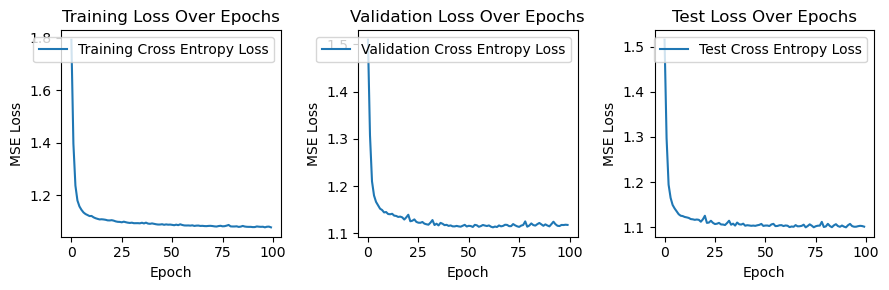

In [13]:
# Plot settings
plt.figure(figsize=(9, 3))

# Training Losses
# Subplot for Training Reconstruction Loss
plt.subplot(1, 3, 1)
plt.plot(train_rec, label='Training Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()


# Validation Losses
# Subplot for Validation Reconstruction Loss
plt.subplot(1, 3, 2)
plt.plot(valid_rec, label='Validation Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()



# Test Losses
# Subplot for Test Reconstruction Loss
plt.subplot(1, 3, 3)
plt.plot(test_rec, label='Test Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Test Loss Over Epochs')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## (2) $X_{n}^{t} = \phi(F_{n}^{t})*\beta_{n} + \epsilon$

Here, $\phi(F_{n})$ refers to the centriod vector of each F clusters, we use a Gaussian likelihood with homoscedastic noise. 

In [14]:
N, T = X_np.shape
_, _, l = F_vec_np.shape

In [15]:
from sklearn.linear_model import Ridge

beta = np.zeros((N, l))

all_residuals = []

for n in range(N):
    X_n = X_np[n, :]  # shape: (T,)
    F_n = F_vec_np[n, :, :]  # shape: (T, l)
    
    # Using linear regression to find the best beta_n
    model = Ridge(alpha=0.01)
    model.fit(F_n, X_n)
    beta[n, :] = model.coef_
    
    # Calculate the residuals
    residuals = X_n - model.predict(F_n)
    all_residuals.extend(residuals)

# Convert residuals list to numpy array for variance calculation
all_residuals = np.array(all_residuals)

# Estimate the shared variance of the residuals
shared_variance = np.var(all_residuals) 

# beta now contains the learned parameters for each user
# shared_variance contains the estimated shared noise variance
print("Learned beta values:", beta)
print("Estimated shared variance:", shared_variance)

Learned beta values: [[-5.83760298e+00  1.53372851e-01 -7.59492248e+00 ... -4.91350602e+00
  -4.75931053e+00 -4.52315834e-01]
 [ 0.00000000e+00  3.69778549e-30  0.00000000e+00 ... -7.39557099e-30
   0.00000000e+00 -1.47911420e-29]
 [ 3.83129445e-02 -1.42255384e-02  4.07906983e-03 ...  9.74656336e-02
  -2.03016637e-01 -6.11208362e-02]
 ...
 [-1.62884160e-04 -1.94785623e-05  3.32469589e-05 ... -1.18514755e-03
   8.73047236e-04 -3.95404665e-04]
 [-1.75950003e+00  6.44878551e-01  4.74484751e+00 ... -9.04351844e+00
   4.21800827e+00 -4.36926707e+00]
 [ 1.45726243e+01 -7.45272906e+00 -1.01593903e+01 ... -8.48095161e-01
  -7.46715241e+00 -6.27127880e+00]]
Estimated shared variance: 4.268698833943258


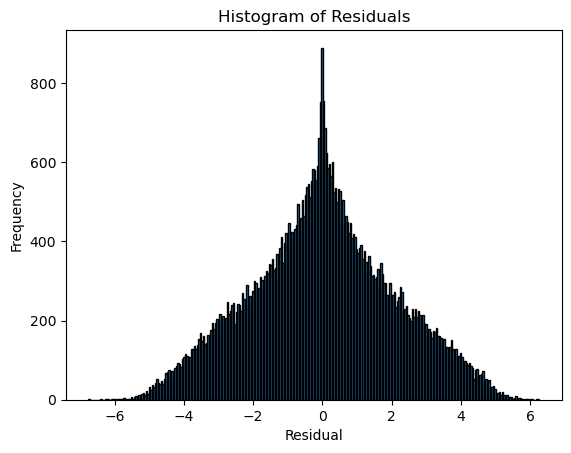

Mean of residuals: 3.552713678800501e-19
Standard deviation of residuals: 2.0660829687946363


In [16]:
import matplotlib.pyplot as plt

plt.hist(all_residuals, bins=300, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Descriptive statistics
print("Mean of residuals:", np.mean(all_residuals))
print("Standard deviation of residuals:", np.std(all_residuals))


In [17]:
data_variance = np.var(X_np)
print("Variance of the original data:", data_variance)

Variance of the original data: 7.447008230654739


In [18]:
beta.shape

(6000, 10)

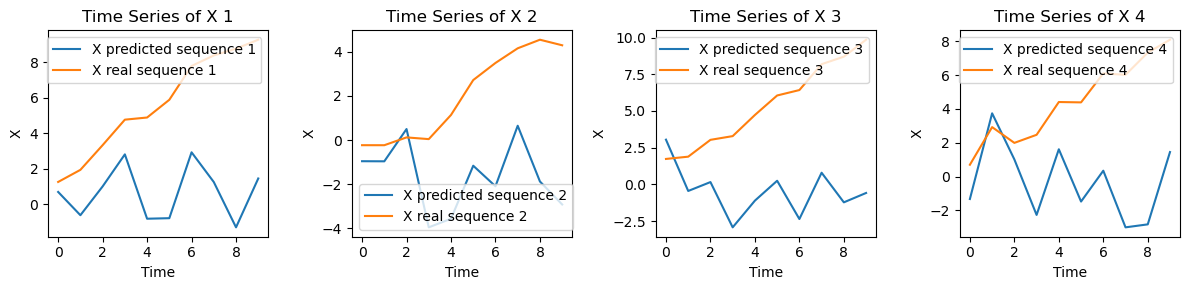

In [19]:
plt.figure(figsize=(12, 3))

num_individuals = 4

for i in range(num_individuals):
    plt.subplot(1, num_individuals, i+1)
    plt.plot(F_vec_np[i] @ beta[i, :] + np.random.normal(0, np.sqrt(shared_variance), size=(F_vec_np[i].shape[0])), label=f'X predicted sequence {i+1}')
    plt.plot(X_np[i], label=f'X real sequence {i+1}')
    plt.xlabel('Time')
    plt.ylabel(f'X')
    plt.title(f'Time Series of X {i+1}')
    plt.legend()
plt.tight_layout()
plt.show()

## We can now use this to generate training data

We need to define the intervention effect, here is an example:

we already know the following from the simulator:

* l = 30
* z = 5
* N = 6000

the model is trained on a time series of length 10 but say we want to have a time series of length T = 21, K = 5 interventions, N = 3000 users and B = 2000 (none-intervention users, B=0). l here indicates the cluster and influence F values.

We define the intervention effects as following:

* K = 0, no intervention effect (1)
* K = 1, change 0-10 cluster values X 2.5 + 0.7
* K = 2, change 15-20 cluster values X -1.5 - 0.3
* K = 3, change 20-30 cluster values X 0.3 + 2.5
* K = 4, change 5-25 cluster values X -0.7 - 1.5


In [20]:
gru_path = './model/gru_simulator' 
gru_simulator_ = gru_model(z_dim, l)
gru_simulator_.load_state_dict(torch.load(gru_path))

<All keys matched successfully>

In [21]:
F_np_flattened = F_np.reshape(-1, F_np.shape[-1])
F_vec_np_flattened = F_vec_np.reshape(-1, F_vec_np.shape[-1])

mapping_dict = {}

# Iterate through the flattened arrays
for index in range(F_np_flattened.shape[0]):
    f_tuple = tuple(F_np_flattened[index])  # Convert the row to a tuple
    f_vec_tuple = tuple(F_vec_np_flattened[index])  # Convert the corresponding row to a tuple
    
    if f_tuple in mapping_dict and mapping_dict[f_tuple] != f_vec_tuple:
        print(f'Error: conflicting mapping for {f_tuple}')
    mapping_dict[f_tuple] = f_vec_tuple

# Print the mapping
print("Mapping from F to F_vec:", mapping_dict)

Mapping from F to F_vec: {(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): (0.0695320313643396, -0.011177622068879926, 0.019096371327942153, -0.021137789717718534, 0.032884183739025796, -0.006809441273951342, -0.015377579459151525, 0.024784032771969763, -0.034827358471394086, -0.03635400060875652), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): (0.06953126222753003, -0.011178203525205396, 0.019096517733528752, -0.02113531657301693, 0.03288330410977734, -0.0068086084962992845, -0.015377306873410731, 0.02478031018086665, -0.03482233066552907, -0.0363537341414304), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0): (0.06953172399542647, -0.011177516303562769, 0.01909643714865018, -0.021135935600947134, 0.03288338719309818, -0.0068079074266940215, -0.015377068038987292, 0.02478125079546106, -0.03482597459037621, -0.036355367985226386), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0): (0.0695004329733046, -0.011181794135149432, 0.019096521236742787, -0.021075938300494833, 0.0328

In [22]:
class params:
    def __init__(self, seed=42):
        self.seed = seed
        self.l = 10
        self.T = 36
        self.T0 = 26
        self.K = 5
        self.N = 5000
        self.M = 1000
        self.z_dim = 5
        self.I = 3

In [23]:
def simulate_D_train(num_intervention, num_individuals, T0, T, max_interventions):
    D = np.zeros((num_individuals, T))
    # max_interventions = num_intervention // 2 + 1
    d_k = np.stack([np.random.choice(num_intervention, max_interventions, replace=False) for i in range(num_individuals)]) 
    d_t = np.stack([np.random.choice(T-T0, max_interventions, replace=False) for i in range(num_individuals)]) 
    for i in range(num_individuals):
        D[i, d_t[i] + T0] = d_k[i]
    for i in range(num_intervention):
        for t in range(T):
            if D[i, t] > 0:
                if t + 1 < T:
                    D[i, t + 1] = 0
                if t + 2 < T:
                    D[i, t + 2] = 0
                if t + 3 < T:
                    D[i, t + 3] = 0

    D[:, -1] = 0

    return D

def simulate_D_test(num_intervention, num_individuals, T0, T, max_interventions):
    T = T + 5
    D = np.zeros((num_individuals, T))
    # max_interventions = num_intervention // 2 + 1
    d_k = np.stack([np.random.choice(num_intervention, max_interventions, replace=False) for i in range(num_individuals)]) 
    d_t = np.stack([np.random.choice(T-T0-5, max_interventions, replace=False) for i in range(num_individuals)]) 
    d_t_ = np.zeros((num_individuals, 1))
    for i in range(num_individuals):
        available_options = set(range(num_intervention)) - set(d_k[i]) - set([0])
        d_t_[i] = np.random.choice(list(available_options), 1, replace=False)
    for i in range(num_individuals):
        D[i, d_t[i] + T0] = d_k[i]
        D[i, T-5] = d_t_[i]
    for i in range(num_intervention):
        for t in range(T-5):
            if D[i, t] > 0:
                if t + 1 < T-5:
                    D[i, t + 1] = 0
                if t + 2 < T-5:
                    D[i, t + 2] = 0
                if t + 3 < T-5:
                    D[i, t + 3] = 0

    D[:, -6] = 0

    return D

In [24]:
def simulate_W(num_intervention, num_latent):

    W_1d = np.zeros((num_intervention, num_latent))
    W_2d = np.zeros((num_intervention, num_latent))
    W_3d = np.ones((num_intervention, num_latent))

    m = (num_latent -1) // 2  + 1

    # # we consider adding intervention D changes the exposure of distributions in each music cluster (amplified or reduce influence)
    # # W_1d here is the shrinkage factor, we initilise them randomly
    # W_1d[:m] = np.random.uniform(1, 5, size=(num_intervention, num_latent))[:m]
    # W_1d[m:] = np.random.uniform(-5, -1, size=(num_intervention, num_latent))[m:]
    # '''
    # * K = 0, no intervention effect (1)
    # * K = 1, change 0-10 cluster values X 20 + 1.7
    # * K = 2, change 15-20 cluster values X -15 - 0.3
    # * K = 3, change 20-30 cluster values X 13 + 2.5
    # * K = 4, change 5-25 cluster values X -10 + 1.5
    # '''
    # W_2d[1, :10] = 20
    # W_3d[1, :10] = 2

    # W_2d[2, 15:20] = -15
    # W_3d[1, 15:20] = -3

    # W_2d[3, 20:30] = 13
    # W_3d[3, 20:30] = 5

    # W_2d[4, 5:25] = -10
    # W_3d[4, 5:25] = 2
    
    
    W_1d[:m] = np.random.uniform(1, 1.5, size=(num_intervention, num_latent))[:m]
    W_1d[m:] = np.random.uniform(-1.5, -1, size=(num_intervention, num_latent))[m:]

    W_2d[:m] = np.random.uniform(1, 1.5, size=(num_intervention, num_latent))[:m]
    W_2d[m:] = np.random.uniform(-1.5, -1, size=(num_intervention, num_latent))[m:]

    W_3d[:m] = np.random.uniform(1.5, 2.0, size=(num_intervention, num_latent))[:m]
    W_3d[m:] = np.random.uniform(0, 0.5, size=(num_intervention, num_latent))[m:]

    W_1d[0] = 0
    W_2d[0] = 0
    W_3d[0] = 1
    
    # print(W_1d)
    # print(W_2d)
    # print(W_3d)
    return W_1d, W_2d, W_3d

In [25]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

def psi(d_t_prime, w_1d, w_2d, w_3d, t, t_prime):
    return (sigmoid(w_1d[d_t_prime])**(t-t_prime)) * w_2d[d_t_prime] + w_3d[d_t_prime]

def psi_product(d_n, w_1d, w_2d, w_3d):
    N, T = d_n.shape
    _, l = w_1d.shape
    d_n_l = np.ones((N, T, l))
    for t in range(T):
        for t_prime in range(t):
            d_n_t_prime = d_n[:, t_prime]
            psi_ = psi(d_n_t_prime.astype(int), w_1d, w_2d, w_3d, t, t_prime)
            d_n_l[:, t, :] = psi_ * d_n_l[:, t, :]

    return d_n_l    

In [26]:
def simulate_x_train(num_individual, num_latent, T, X_np, F_np, mapping_F_F_vec, gru_model, variance, psi, Z, beta):
    X_full = np.zeros((num_individual, T+1))
    F_full = np.zeros((num_individual, T+1, num_latent))

    X_full_0 = np.zeros((num_individual, T+1))
    F_full_0 = np.zeros((num_individual, T+1, num_latent))

    X_full[:, 0] = X_np[:num_individual, 0]
    X_full_0[:, 0] = X_np[:num_individual, 0]

    F_full[:, 0, :] = F_np[:num_individual, 0, :]
    F_full_0[:, 0, :] = F_np[:num_individual, 0, :]

    X_noise = np.random.normal(0, np.sqrt(variance), size=(num_individual, T))

    with torch.no_grad():
        for t in range(T):

            X_current = X_full[:, :t+1]
            F_current = F_full[:, :t+1, :]

            X_current_0 = X_full_0[:, :t+1]
            F_current_0 = F_full_0[:, :t+1, :]

            F_now = gru_model(torch.from_numpy(X_current), torch.from_numpy(Z), torch.from_numpy(F_current)).cpu().detach().numpy()[:, -1, :]
            F_now_0 = gru_model(torch.from_numpy(X_current_0), torch.from_numpy(Z), torch.from_numpy(F_current_0)).cpu().detach().numpy()[:, -1, :]

            F_now = F_now * psi[:, t]

            F_now_prob = softmax(F_now, axis=-1)
            F_now_prob_0 = softmax(F_now_0, axis=-1)


            F_now_prob = F_now_prob / np.sum(F_now_prob)
            F_now_prob_0 = F_now_prob_0 / np.sum(F_now_prob_0)
            
            F_now = np.array([np.random.multinomial(1, p) for p in F_now_prob])
            F_now_0 = np.array([np.random.multinomial(1, p) for p in F_now_prob_0])
            
            F_now_vector = np.array([np.array(mapping_F_F_vec[tuple(p)]) for p in F_now])
            F_now_0_vector = np.array([np.array(mapping_F_F_vec[tuple(p)]) for p in F_now_0])

            
            F_full[:, t+1] = F_now
            F_full_0[:, t+1] = F_now_0

            # print(F_now_vector.shape)
            # print(psi[:, t].shape)
            # print(beta[:].shape)
            # print(X_noise[:, t].shape)

            X_now = np.sum(F_now_vector * psi[:, t] * beta[:], axis=-1) + X_noise[:, t]
            X_now_0 = np.sum(F_now_0_vector * beta[:], axis=-1) + X_noise[:, t]

            # print(X_now[0] - X_now_0[0])

            X_full[:, t+1] = X_now
            X_full_0[:, t+1] = X_now_0
    
    X_final = X_full[:, 1:]
    X_final_0 = X_full_0[:, 1:]
    return X_final, X_final_0


In [27]:
def simulate_x_test(num_individual, num_latent, T, X_np, F_np, mapping_F_F_vec, gru_model, variance, psi, Z, beta, num_samples=50):
    X_full = np.zeros((num_individual, T+1+5, num_samples))
    F_full = np.zeros((num_individual, T+1+5, num_latent, num_samples))
    # F_relax = np.zeros((num_individual, T+1+5, num_latent, num_samples))

    X_full_0 = np.zeros((num_individual, T+1+5, num_samples))
    F_full_0 = np.zeros((num_individual, T+1+5, num_latent, num_samples))
    # F_relax_0 = np.zeros((num_individual, T+1+5, num_latent, num_samples))

    X_full[:, 0, 0] = X_np[-num_individual:, 0]
    X_full_0[:, 0, 0] = X_np[-num_individual:, 0]

    F_full[:, 0, :, 0] = F_np[-num_individual:, 0, :]
    F_full_0[:, 0, :, 0] = F_np[-num_individual:, 0, :]

    # F_relax[:, 0, :, 0] = F_np[-num_individual:, 0, :]
    # F_relax_0[:, 0, :, 0] = F_np[-num_individual:, 0, :]

    # np.random.normal(0, np.sqrt(variance), size=(num_individual, T))

    X_noise = np.random.normal(0, np.sqrt(variance), size=(num_individual, T+5, num_samples))

    


    with torch.no_grad():
        for t in range(T):

            X_current = X_full[:, :t+1, 0]
            F_current = F_full[:, :t+1, :, 0]

            X_current_0 = X_full_0[:, :t+1, 0]
            F_current_0 = F_full_0[:, :t+1, :, 0]

            F_now = gru_model(torch.from_numpy(X_current), torch.from_numpy(Z), torch.from_numpy(F_current)).cpu().detach().numpy()[:, -1, :]
            F_now_0 = gru_model(torch.from_numpy(X_current_0), torch.from_numpy(Z), torch.from_numpy(F_current_0)).cpu().detach().numpy()[:, -1, :] 
            
            F_now = F_now * psi[:, t]
            
            F_now_prob = softmax(F_now, axis=-1)
            F_now_prob_0 = softmax(F_now_0, axis=-1)

            # F_now_prob = F_now_prob * psi[:, t]

            F_now_prob = F_now_prob / np.sum(F_now_prob)
            F_now_prob_0 = F_now_prob_0 / np.sum(F_now_prob_0)
            
            F_now = np.array([np.random.multinomial(1, p) for p in F_now_prob])
            F_now_0 = np.array([np.random.multinomial(1, p) for p in F_now_prob_0])

            F_now_vector = np.array([np.array(mapping_F_F_vec[tuple(p)]) for p in F_now])
            F_now_0_vector = np.array([np.array(mapping_F_F_vec[tuple(p)]) for p in F_now_0])
            
            F_full[:, t+1, :, 0] = F_now
            F_full_0[:, t+1, :, 0] = F_now_0

            X_now = np.sum(F_now_vector * psi[:, t] * beta[:], axis=-1) + X_noise[:, t, 0]
            X_now_0 = np.sum(F_now_0_vector * beta[:], axis=-1) + X_noise[:, t, 0]

            # X_now = linear_model.predict(F_full[:, t+1, :, 0]) + X_noise[:, t, 0]
            # X_now_0 = linear_model.predict(F_full_0[:, t+1, :, 0]) + X_noise[:, t, 0]

            X_full[:, t+1, 0] = X_now
            X_full_0[:, t+1, 0] = X_now_0
    
        X_full[:, :T+1] = np.tile(X_full[:, :T+1, 0][:, :, np.newaxis], (1, 1, num_samples))
        X_full_0[:, :T+1] = np.tile(X_full_0[:, :T+1, 0][:, :, np.newaxis], (1, 1, num_samples))

        F_full[:, :T+1] = np.tile(F_full[:, :T+1, :, 0][:, :, :, np.newaxis], (1, 1, 1, num_samples))
        F_full_0[:, :T+1] = np.tile(F_full_0[:, :T+1, :, 0][:, :, :,  np.newaxis], (1, 1, 1, num_samples))



        for t in range(T, T+5):
            for j in range(num_samples):

                X_current = X_full[:, :t+1, j]
                F_current = F_full[:, :t+1, :, j]

                X_current_0 = X_full_0[:, :t+1, j]
                F_current_0 = F_full_0[:, :t+1, :, j]

                F_now = gru_model(torch.from_numpy(X_current), torch.from_numpy(Z), torch.from_numpy(F_current)).cpu().detach().numpy()[:, -1, :]
                F_now_0 = gru_model(torch.from_numpy(X_current_0), torch.from_numpy(Z), torch.from_numpy(F_current_0)).cpu().detach().numpy()[:, -1, :]
                
                F_now = F_now * psi[:, t]

                F_now_prob = softmax(F_now, axis=-1)
                F_now_prob_0 = softmax(F_now_0, axis=-1)

                # F_now_prob = F_now_prob * psi[:, t]

                F_now_prob = F_now_prob / np.sum(F_now_prob)
                F_now_prob_0 = F_now_prob_0 / np.sum(F_now_prob_0)
                
                F_now = np.array([np.random.multinomial(1, p) for p in F_now_prob])
                F_now_0 = np.array([np.random.multinomial(1, p) for p in F_now_prob_0])
                
                F_now_vector = np.array([np.array(mapping_F_F_vec[tuple(p)]) for p in F_now])
                F_now_0_vector = np.array([np.array(mapping_F_F_vec[tuple(p)]) for p in F_now_0])

                # F_now_vector = F_now_vector * psi[:, t]
                
                F_full[:, t+1, :, j] = F_now
                F_full_0[:, t+1, :, j] = F_now_0

                # X_now = linear_model.predict(F_full[:, t+1, :, j]) + X_noise[:, t, j]
                # X_now_0 = linear_model.predict(F_full_0[:, t+1, :, j]) + X_noise[:, t, j]

                X_now = np.sum(F_now_vector * psi[:, t] * beta[:], axis=-1) + X_noise[:, t, j]
                X_now_0 = np.sum(F_now_0_vector * beta[:], axis=-1) + X_noise[:, t, j]

                X_full[:, t+1, j] = X_now
                X_full_0[:, t+1, j] = X_now_0

    X_final = X_full[:, 1:]
    X_final_0 = X_full_0[:, 1:]
    return X_final, X_final_0



In [28]:
def save_data(D_train, D_test, X_train, X_train0, X_test, X_test0, Z_train, Z_test, PARAMS):

    print(f'D_train shape of {D_train.shape}')
    print(f'D_test shape of {D_test.shape}')

    print(f'X_train shape of {X_train.shape}')
    print(f'X_train0 shape of {X_train0.shape}')

    print(f'X_test shape of {X_test.shape}')
    print(f'X_test0 shape of {X_test0.shape}')

    print(f'Z_train shape of {Z_train.shape}')
    print(f'Z_test shape of {Z_test.shape}')

    seed = PARAMS.seed

    np.save(f'./data/d_train_{seed}.npy', D_train)
    np.save(f'./data/d_test_{seed}.npy', D_test)

    np.save(f'./data/x_train_{seed}.npy', X_train)
    np.save(f'./data/x_test_{seed}.npy', X_test)

    np.save(f'./data/x_train0_{seed}.npy', X_train0)
    np.save(f'./data/x_test0_{seed}.npy', X_test0)
    
    np.save(f'./data/z_train_{seed}.npy', Z_train)
    np.save(f'./data/z_test_{seed}.npy', Z_test)

In [29]:
def simulator(PARAMS, X_np, Z_np, F_np, gru_model, variance, mapping_F_F_vec, beta):

    set_seed(PARAMS.seed)
    W_1d, W_2d, W_3d = simulate_W(PARAMS.K, PARAMS.l)
    D_train = simulate_D_train(PARAMS.K, PARAMS.N, PARAMS.T0, PARAMS.T, PARAMS.I)
    D_test = simulate_D_test(PARAMS.K, PARAMS.M, PARAMS.T0, PARAMS.T, PARAMS.I)
    psi_train = psi_product(D_train, W_1d, W_2d, W_3d)
    psi_test = psi_product(D_test, W_1d, W_2d, W_3d)
    beta_train, beta_test = beta[:PARAMS.N], beta[-PARAMS.M:]
    # print(psi_train.shape)
    Z_train, Z_test = Z_np[:PARAMS.N, :], Z_np[-PARAMS.M:, :]
    # X0_train, X0_test = X0[:PARAMS.N], X0[PARAMS.N:PARAMS.N+PARAMS.M]
    # lstm_model = SyntheticLSTM(PARAMS.z_dim, PARAMS.l)
    X_train, X_train0 = simulate_x_train(PARAMS.N, PARAMS.l, PARAMS.T, X_np, F_np, mapping_F_F_vec, gru_model, variance, psi_train, Z_train, beta_train)
    X_test, X_test0 = simulate_x_test(PARAMS.M, PARAMS.l, PARAMS.T, X_np, F_np, mapping_F_F_vec, gru_model, variance, psi_test, Z_test, beta_test)
    
    return D_train, D_test, X_train, X_train0, X_test, X_test0, Z_train, Z_test




In [30]:

for i in range(5):
    PARAMS = params(i+1)
    D_train, D_test, X_train, X_train0, X_test, X_test0, Z_train, Z_test =  simulator(PARAMS, X_np, Z_np, F_np, gru_simulator_, shared_variance, mapping_dict, beta)
    save_data(D_train, D_test, X_train, X_train0, X_test, X_test0, Z_train, Z_test, PARAMS)

D_train shape of (5000, 36)
D_test shape of (1000, 41)
X_train shape of (5000, 36)
X_train0 shape of (5000, 36)
X_test shape of (1000, 41, 50)
X_test0 shape of (1000, 41, 50)
Z_train shape of (5000, 5)
Z_test shape of (1000, 5)
D_train shape of (5000, 36)
D_test shape of (1000, 41)
X_train shape of (5000, 36)
X_train0 shape of (5000, 36)
X_test shape of (1000, 41, 50)
X_test0 shape of (1000, 41, 50)
Z_train shape of (5000, 5)
Z_test shape of (1000, 5)
D_train shape of (5000, 36)
D_test shape of (1000, 41)
X_train shape of (5000, 36)
X_train0 shape of (5000, 36)
X_test shape of (1000, 41, 50)
X_test0 shape of (1000, 41, 50)
Z_train shape of (5000, 5)
Z_test shape of (1000, 5)
D_train shape of (5000, 36)
D_test shape of (1000, 41)
X_train shape of (5000, 36)
X_train0 shape of (5000, 36)
X_test shape of (1000, 41, 50)
X_test0 shape of (1000, 41, 50)
Z_train shape of (5000, 5)
Z_test shape of (1000, 5)
D_train shape of (5000, 36)
D_test shape of (1000, 41)
X_train shape of (5000, 36)
X_tra

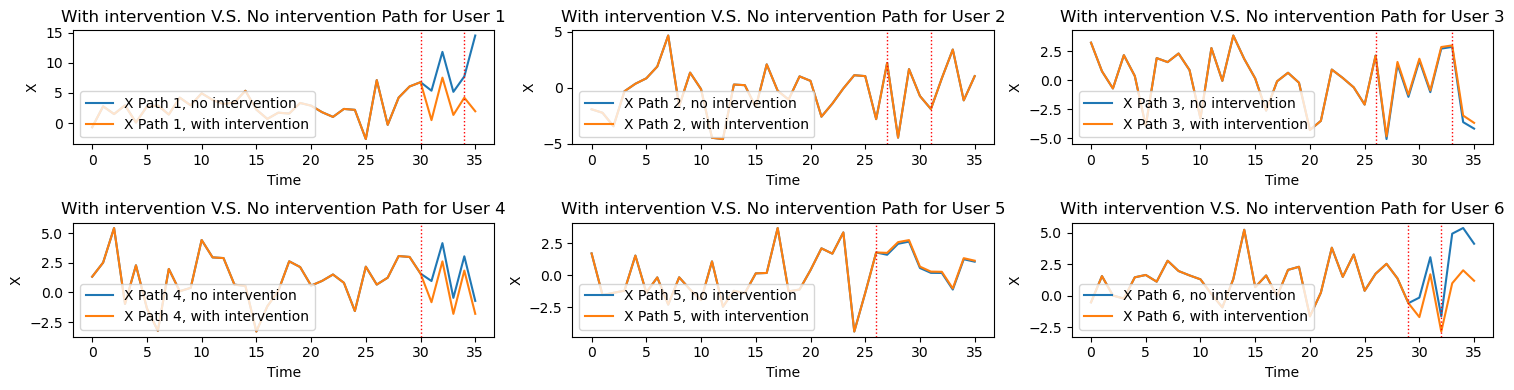

In [31]:
num_individuals = 6

assert num_individuals < N, f'Can not plot {num_individuals} paths when N is set as {N}'
# Plot settings

plt.figure(figsize=(15, 4))  # Adjusting the size for six subplots

for i in range(num_individuals):
    plt.subplot(2, 3, i+1)
    plt.plot(X_train[i], label=f'X Path {i+1}, no intervention')
    plt.plot(X_train0[i], label=f'X Path {i+1}, with intervention')
    # plt.plot(rec_x_test.detach().numpy()[i, :], label=f'Recons Path {i+1}')
    intervention_indices = np.where(D_train[i] != 0)[0]  # Find indices where intervention is not zero
    for idx in intervention_indices:
        plt.axvline(x=idx, color='r', linestyle=':', linewidth=1)  # Plot a vertical line at each intervention index
    plt.xlabel('Time')
    plt.ylabel('X')
    plt.title(f'With intervention V.S. No intervention Path for User {i+1}')
    plt.legend(loc='lower left')

# Show the plots
plt.tight_layout()
plt.show()


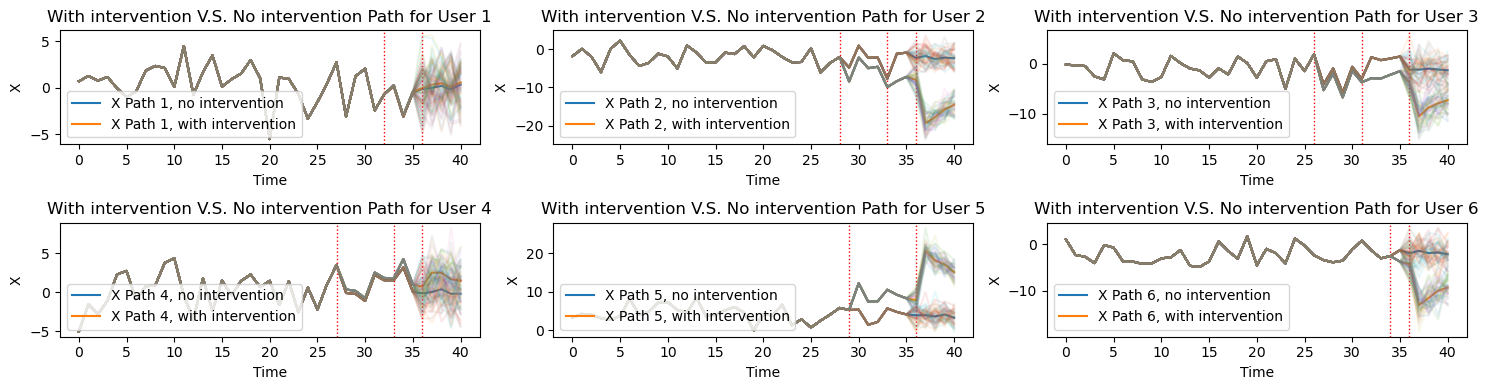

In [32]:
num_individuals = 6

assert num_individuals < N, f'Can not plot {num_individuals} paths when N is set as {N}'
# Plot settings

plt.figure(figsize=(15, 4))  # Adjusting the size for six subplots

for i in range(num_individuals):
    plt.subplot(2, 3, i+1)
    plt.plot(np.mean(X_test0, axis=-1)[i], label=f'X Path {i+1}, no intervention')
    plt.plot(np.mean(X_test, axis=-1)[i], label=f'X Path {i+1}, with intervention')
    # plt.plot(rec_x_test.detach().numpy()[i, :], label=f'Recons Path {i+1}')
    intervention_indices = np.where(D_test[i] != 0)[0]  # Find indices where intervention is not zero
    for idx in intervention_indices:
        plt.axvline(x=idx, color='r', linestyle=':', linewidth=1)  # Plot a vertical line at each intervention index
    
    for j in range(X_test.shape[-1]):
        plt.plot(X_test[i, :, j], alpha=0.1)
        plt.plot(X_test0[i, :, j], alpha=0.1)
    plt.xlabel('Time')
    plt.ylabel('X')
    plt.title(f'With intervention V.S. No intervention Path for User {i+1}')
    plt.legend(loc='lower left')

# Show the plots
plt.tight_layout()
plt.show()


In [33]:
# print(f'Have training X of shape {X_train.shape}, D of shape {D_train.shape}, Z of shape {Z_train.shape}')
# print(f'Have testing X of shape {X_test.shape}, D of shape {D_test.shape}, Z of shape {Z_test.shape}')

# np.save('./data/x_train.npy', X_train)
# np.save('./data/x_train_0.npy', X_train0)
# np.save('./data/d_train.npy', D_train)
# np.save('./data/z_train.npy', Z_train)

# np.save('./data/x_test.npy', X_test)
# np.save('./data/x_test_0.npy', X_test0)
# np.save('./data/d_test.npy', D_test)
# np.save('./data/z_test.npy', Z_test)